## 1. Get video indeces of outlier patients
## 2. Segment any video from those indeces (pass thru model) and look at the segmentation manually and see what's up
## 3. Compare visual results with that in the CSV file

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display

In [2]:
name = 'Original_Pretrained_R2plus1DMotionSegNet.pthlog.csv'

data = pd.read_csv(f'./csvs/previous_saves/{name}')

For now, let's look at outlier patients with a "low" (i.e. arbitrary cutoff, I just said less than 0.8) Dice score, i.e., a low score of overlapping with the ground truth ED / ES frames.

In [3]:
patients_with_low_dice = data.query("`ED Dice` < 0.80 or `ES Dice` < 0.80")
outlier_patient_vid_indeces = np.array(patients_with_low_dice['Video Index'])

In [5]:
# %config Completer.use_jedi = False

import SimpleITK as itk
from LabelFusion.wrapper import fuse_images

import echonet
from echonet.datasets import Echo

import torch.nn.functional as F
from torchvision.models.video import r2plus1d_18
from torch.utils.data import Dataset, DataLoader, Subset
from multiprocessing import cpu_count

from src.utils.torch_utils import TransformDataset, torch_collate
from src.utils.echo_utils import get2dPucks
from src.utils.camus_validate import cleanupSegmentation
from src.transform_utils import generate_2dmotion_field
from src.visualization_utils import categorical_dice
from src.loss_functions import huber_loss, convert_to_1hot, convert_to_1hot_tensor
from src.echonet_dataset import EDESpairs, EchoNetDynamicDataset

from src.model.R2plus1D_18_MotionNet import R2plus1D_18_MotionNet

# v1 dropout, not in place dropout
from src.model.dropout_0_10_R2plus1D_18_MotionNet import dropout_0_10_R2plus1D_18_MotionNet
from src.model.dropout_0_25_R2plus1D_18_MotionNet import dropout_0_25_R2plus1D_18_MotionNet
from src.model.dropout_0_50_R2plus1D_18_MotionNet import dropout_0_50_R2plus1D_18_MotionNet
from src.model.dropout_0_75_R2plus1D_18_MotionNet import dropout_0_75_R2plus1D_18_MotionNet

# v2 dropout (in place before motion heads, forgot to define in forward pass function, but still saw diff, weird.)
from src.model.dropout_v2_0_00_R2plus1D_18_MotionNet import dropout_v2_0_00_R2plus1D_18_MotionNet
from src.model.dropout_v2_0_10_R2plus1D_18_MotionNet import dropout_v2_0_10_R2plus1D_18_MotionNet
from src.model.dropout_v2_0_25_R2plus1D_18_MotionNet import dropout_v2_0_25_R2plus1D_18_MotionNet
from src.model.dropout_v2_0_50_R2plus1D_18_MotionNet import dropout_v2_0_50_R2plus1D_18_MotionNet
from src.model.dropout_v2_0_75_R2plus1D_18_MotionNet import dropout_v2_0_75_R2plus1D_18_MotionNet
# v3 dropout (one dropout layer defined in forward pass func, this should've been the correct way to do it.)
from src.model.dropout_v3_0_00_R2plus1D_18_MotionNet import dropout_v3_0_00_R2plus1D_18_MotionNet
from src.model.dropout_v3_0_10_R2plus1D_18_MotionNet import dropout_v3_0_10_R2plus1D_18_MotionNet
from src.model.dropout_v3_0_25_R2plus1D_18_MotionNet import dropout_v3_0_25_R2plus1D_18_MotionNet
from src.model.dropout_v3_0_50_R2plus1D_18_MotionNet import dropout_v3_0_50_R2plus1D_18_MotionNet
from src.model.dropout_v3_0_75_R2plus1D_18_MotionNet import dropout_v3_0_75_R2plus1D_18_MotionNet
# v4 dropout (4 dropout layers in different places in the forward func, I'm going to guess more "generalizable")
from src.model.dropout_v4_0_00_R2plus1D_18_MotionNet import dropout_v4_0_00_R2plus1D_18_MotionNet
from src.model.dropout_v4_0_10_R2plus1D_18_MotionNet import dropout_v4_0_10_R2plus1D_18_MotionNet
from src.model.dropout_v4_0_25_R2plus1D_18_MotionNet import dropout_v4_0_25_R2plus1D_18_MotionNet
from src.model.dropout_v4_0_50_R2plus1D_18_MotionNet import dropout_v4_0_50_R2plus1D_18_MotionNet
from src.model.dropout_v4_0_75_R2plus1D_18_MotionNet import dropout_v4_0_75_R2plus1D_18_MotionNet



# for finding lv seg borders
import cv2 as cv


# from src.visualization_utils import categorical_dice

import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import random
import pickle
import time

tic, toc = (time.time, time.time)

batch_size = 4
num_workers = max(4, cpu_count()//2)


def worker_init_fn_valid(worker_id):                                                          
    np.random.seed(np.random.get_state()[1][0] + worker_id)
    

def worker_init_fn(worker_id):
    # See here: https://pytorch.org/docs/stable/notes/randomness.html#dataloader
    # and the original post of the problem: https://github.com/pytorch/pytorch/issues/5059#issuecomment-817373837
    worker_seed = torch.initial_seed() % 2 ** 32
    print(f'worker_seed: {worker_seed}')
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    

def permuter(list1, list2):
    for i1 in list1:
        for i2 in list2:
            yield (i1, i2)
            

param_trainLoader = {'collate_fn': torch_collate,
                     'batch_size': batch_size,
                     'num_workers': max(4, cpu_count()//2),
                     'worker_init_fn': worker_init_fn}

param_testLoader = {'collate_fn': torch_collate,
                    'batch_size': batch_size,
                    'shuffle': False,
                    'num_workers': max(4, cpu_count()//2),
                    'worker_init_fn': worker_init_fn}

paramLoader = {'train': param_trainLoader,
               'valid': param_testLoader,
               'test':  param_testLoader}

with open("fold_indexes/stanford_valid_sampled_indices", "rb") as infile:
    valid_mask = pickle.load(infile)
infile.close()

test_dataset = EchoNetDynamicDataset(split='test', clip_length="full", raise_for_es_ed=False, period=1)

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.95it/s]


In [6]:
model_name = "Original_Pretrained_R2plus1DMotionSegNet.pth"
device = "cuda"

In [8]:
model_save_path = f"save_models/{model_name}"     
    
if model_name == 'Original_Pretrained_R2plus1DMotionSegNet.pth':
    model_template_obj = R2plus1D_18_MotionNet()
elif model_name == 'retrain_original_R2plus1DMotionSegNet.pth':
    model_template_obj = R2plus1D_18_MotionNet()
elif model_name == 'dropout_v2_0_00_R2plus1DMotionSegNet.pth':
    model_template_obj = dropout_v2_0_00_R2plus1D_18_MotionNet()
elif model_name == 'dropout_v2_0_10_R2plus1DMotionSegNet.pth':
    model_template_obj = dropout_v2_0_10_R2plus1D_18_MotionNet()
elif model_name == 'dropout_v2_0_25_R2plus1DMotionSegNet.pth':
    model_template_obj = dropout_v2_0_25_R2plus1D_18_MotionNet()
elif model_name == 'dropout_v2_0_50_R2plus1DMotionSegNet.pth':
    model_template_obj = dropout_v2_0_50_R2plus1D_18_MotionNet()
elif model_name == 'dropout_v2_0_75_R2plus1DMotionSegNet.pth':
    model_template_obj = dropout_v2_0_75_R2plus1D_18_MotionNet()

elif model_name == "dropout_v3_0_00_R2plus1D_18_MotionNet.pth":
    model_template_obj = dropout_v3_0_00_R2plus1D_18_MotionNet()
elif model_name == "dropout_v3_0_10_R2plus1D_18_MotionNet.pth":
    model_template_obj = dropout_v3_0_10_R2plus1D_18_MotionNet()
elif model_name == "dropout_v3_0_25_R2plus1D_18_MotionNet.pth":
    model_template_obj = dropout_v3_0_25_R2plus1D_18_MotionNet()
elif model_name == "dropout_v4_0_00_R2plus1D_18_MotionNet.pth":
    model_template_obj = dropout_v4_0_00_R2plus1D_18_MotionNet()
elif model_name == "dropout_v4_0_10_R2plus1D_18_MotionNet.pth":
    model_template_obj = dropout_v4_0_10_R2plus1D_18_MotionNet()
elif model_name == "dropout_v4_0_25_R2plus1D_18_MotionNet.pth":
    model_template_obj = dropout_v4_0_25_R2plus1D_18_MotionNet()


model = torch.nn.DataParallel(model_template_obj)
model.to(device)
torch.cuda.empty_cache()
model.load_state_dict(torch.load(model_save_path)["model"])
print(f'{model_name} has {sum(p.numel() for p in model.parameters() if p.requires_grad)} parameters.')
model.eval();

Original_Pretrained_R2plus1DMotionSegNet.pth has 31575731 parameters.


In [9]:
def divide_to_consecutive_clips(video, clip_length=32, interpolate_last=False):
    source_video = video.copy()
    video_length = video.shape[1]
    left = video_length % clip_length
    if left != 0 and interpolate_last:
        source_video = torch.Tensor(source_video).unsqueeze(0)
        source_video = F.interpolate(source_video, size=(int(np.round(video_length / clip_length) * clip_length), 112, 112),
                                     mode="trilinear", align_corners=False)
        source_video = source_video.squeeze(0).squeeze(0)
        source_video = source_video.numpy()
    
    videos = np.empty(shape=(1, 3, clip_length, 112, 112))

    for start in range(0, int(clip_length * np.round(video_length / clip_length)), clip_length):
        one_clip = source_video[:, start: start + clip_length]
        one_clip = np.expand_dims(one_clip, 0)
        videos = np.concatenate([videos, one_clip])
    return videos[1:]


def segment_a_video_with_fusion(curr_model, video, interpolate_last=True, step=1, num_clips=10, 
                                fuse_method="simple", class_list=[0, 1]):
    if video.shape[1] < 32 + num_clips * step:
        num_clips = (video.shape[1] - 32) // step
    if num_clips < 0:
        print("Video is too short\n")
        num_clips = 1
    all_consecutive_clips = []

    for shift_dis in range(0, num_clips * step, step):
        shifted_video = video[:, shift_dis:]
        consecutive_clips = divide_to_consecutive_clips(shifted_video, interpolate_last=interpolate_last)
        all_consecutive_clips.append(consecutive_clips)

    all_consecutive_clips = np.array(all_consecutive_clips)
    all_segmentations = []

    for i in range(len(all_consecutive_clips)):
        consecutive_clips = all_consecutive_clips[i]
        segmentation_outputs = np.empty(shape=(1, 2, 32, 112, 112))

        for i in range(consecutive_clips.shape[0]):
            one_clip = np.expand_dims(consecutive_clips[i], 0)
            segmentation_output, motion_output = curr_model(torch.Tensor(one_clip))
            segmentation_output = F.softmax(segmentation_output, 1)
            segmentation_outputs = np.concatenate([segmentation_outputs, segmentation_output.cpu().detach().numpy()])
        segmentation_outputs = segmentation_outputs[1:]

        all_segmentations.append(segmentation_outputs)

    for i in range(len(all_segmentations)):
        all_segmentations[i] = all_segmentations[i].transpose([1, 0, 2, 3, 4])
        all_segmentations[i] = all_segmentations[i].reshape(2, -1, 112, 112)

    all_interpolated_segmentations = []
    for i in range(0, len(all_consecutive_clips)):
        video_clip = video[:, i * step:]
        if interpolate_last and (video_clip.shape[1] % 32 != 0):
            interpolated_segmentations = torch.Tensor(all_segmentations[i]).unsqueeze(0)
            interpolated_segmentations = F.interpolate(interpolated_segmentations, size=(video_clip.shape[1], 112, 112), 
                                                       mode="trilinear", align_corners=False)
            interpolated_segmentations = interpolated_segmentations.squeeze(0).numpy()
            all_interpolated_segmentations.append(np.argmax(interpolated_segmentations, 0))
        else:
            all_interpolated_segmentations.append(np.argmax(all_segmentations[i], 0))

    fused_segmentations = [all_interpolated_segmentations[0][0]]

    for i in range(1, video.shape[1]):
        if step - 1 < i:
            images_to_fuse = []
            for index in range(min(i, len(all_interpolated_segmentations))):
                if i - index * step < 0:
                    break
                images_to_fuse.append(itk.GetImageFromArray(all_interpolated_segmentations[index][i - index * step].astype("uint8"),
                                                            isVector=False))
            if len(images_to_fuse) <= 1:
                fused_segmentations.append(itk.GetArrayFromImage(images_to_fuse[0]))
            else:
                fused_image = fuse_images(images_to_fuse, fuse_method, class_list=class_list)
                # If using SIMPLE, the fused image might be in type "float"
                # So convert it to uint
                fused_segmentations.append(itk.GetArrayFromImage(fused_image).astype("uint8"))

    fused_segmentations = np.array(fused_segmentations)
    
    return fused_segmentations


def compute_ef_using_putative_clips(fused_segmentations, test_pat_index):
    size = np.sum(fused_segmentations, axis=(1, 2)).ravel()
    _05cut, _85cut, _95cut = np.percentile(size, [5, 85, 95]) 

    trim_min = _05cut
    trim_max = _95cut
    trim_range = trim_max - trim_min
    systole = find_peaks(-size, distance=20, prominence=(0.50 * trim_range))[0]
    diastole = find_peaks(size, distance=20, prominence=(0.50 * trim_range))[0]

    # keep only real diastoles..
    diastole = [x for x in diastole if size[x] >= _85cut]
    # Add first frame
    if np.mean(size[:3]) >= _85cut:
        diastole = [0] + diastole
    diastole = np.array(diastole)

    clip_pairs = EDESpairs(diastole, systole)

    one_array_of_segmentations = fused_segmentations.reshape(-1, 112, 112)

    predicted_efs = []

    for i in range(len(clip_pairs)):
        output_ED = one_array_of_segmentations[clip_pairs[i][0]]
        output_ES = one_array_of_segmentations[clip_pairs[i][1]]
        
        length_ed, radius_ed = get2dPucks((output_ED == 1).astype('int'), (1.0, 1.0))
        length_es, radius_es = get2dPucks((output_ES == 1).astype('int'), (1.0, 1.0))

        edv = np.sum(((np.pi * radius_ed * radius_ed) * length_ed / len(radius_ed)))
        esv = np.sum(((np.pi * radius_es * radius_es) * length_es / len(radius_es)))

        ef_predicted = (edv - esv) / edv * 100
        
        if ef_predicted < 0:
            print("Negative EF at patient:{:04d}".format(test_pat_index))
            continue

        predicted_efs.append(ef_predicted)

    return predicted_efs


def compute_ef_using_reported_clip(segmentations, ed_index, es_index):
    output_ED = segmentations[ed_index]
    output_ES = segmentations[es_index]

    lv_ed_dice = categorical_dice((output_ED), ed_label, 1)
    lv_es_dice = categorical_dice((output_ES), es_label, 1)

    length_ed, radius_ed = get2dPucks((output_ED == 1).astype('int'), (1.0, 1.0))
    length_es, radius_es = get2dPucks((output_ES == 1).astype('int'), (1.0, 1.0))
    
    edv = np.sum(((np.pi * radius_ed * radius_ed) * length_ed / len(radius_ed)))
    esv = np.sum(((np.pi * radius_es * radius_es) * length_es / len(radius_es)))

    ef_predicted = (edv - esv) / edv * 100
    
    return ef_predicted, lv_ed_dice, lv_es_dice

In [10]:
def show_outlier(ind):
    '''
    input: ind (integer) 
    output: matplotlib figures and pandas dataframe displays on the outlier patient requested via video index
    '''
    # show the patient's info from dataframe
    # using IPython's display
    display(patients_with_low_dice.query(f"`Video Index` == '{ind}'"))
    
    # use index as video index within the test dataset indeces range
    test_pat_index = ind

    # get video and other info from test dataset
    video, (filename, EF, es_clip_index, ed_clip_index, es_index, ed_index, es_frame, ed_frame, es_label, ed_label) = test_dataset[test_pat_index]
    
    # use model to segment this specific video
    num_clips = 5
    step = 1
    interpolate_last = True
    fuse_method = "simple"
    class_list = [0, 1]

    segmentations = segment_a_video_with_fusion(model, video, interpolate_last=interpolate_last, 
                                                            step=step, num_clips=num_clips,
                                                            fuse_method=fuse_method, class_list=class_list)
    
    # show the figures 
    fig, ax = plt.subplots(3, 2, figsize=(10, 10))

    ax[0][0].set_title('ed label')
    ax[0][0].imshow(ed_label, cmap='gray')
    ax[0][1].set_title('es label')
    ax[0][1].imshow(es_label, cmap='gray')

    ax[1][0].set_title('ed seg')
    ax[1][0].imshow(segmentations[ed_index], cmap="gray")
    ax[1][1].set_title('es seg')
    ax[1][1].imshow(segmentations[es_index], cmap="gray")

    ax[2][0].set_title('ed frame')
    ax[2][0].imshow(video[0][ed_index], cmap="gray")
    ax[2][1].set_title('es frame')
    ax[2][1].imshow(video[0][es_index], cmap="gray")

# Now you can Manually look at the outliers

In [11]:
outlier_patient_vid_indeces

array(['5', '70', '77', '86', '105', '111', '128', '152', '156', '194',
       '222', '230', '258', '264', '298', '314', '324', '338', '351',
       '363', '380', '446', '490', '496', '499', '510', '522', '584',
       '587', '592', '601', '616', '686', '689', '742', '752', '771',
       '773', '877', '900', '908', '913', '932', '992', '998', '1005',
       '1027', '1047', '1268', '1271'], dtype=object)

,Video Index,Predicted EF,True EF,Predicted GLS,True GLS,ED Dice,ES Dice
86,86,43.513382,58.833462,-0.088,-0.126866,0.903642,0.753827


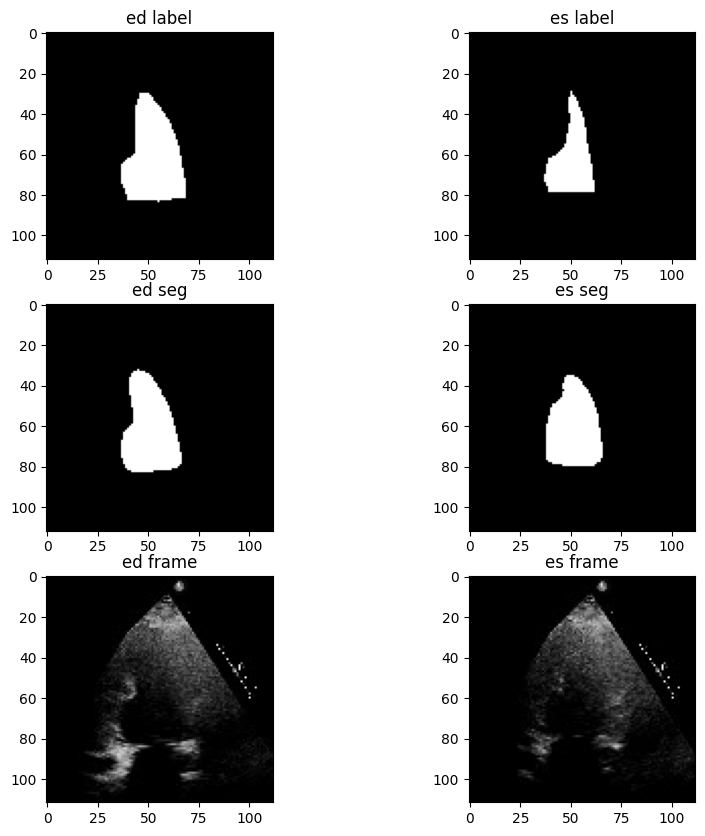

In [12]:
# choose an index listed above
ind = 86

show_outlier(ind)

This is a very interesting example, imo! The ES segmentation by the model kinda looks larger than the ED frame! To be fair to the model, to the untrained eye, it visually looks hard if I were given the task to segment the Left Ventricle myself. The ground truth looks very interesting to, it looks like a very unnatural shape, but I don't exactly have the authority to challenge the technician who segmented that by hand.